# IMO - Zadanie 2

Autorzy: Joanna Cicha, Przemysław Łabuń, Maciej Mak

---

Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import time
import multiprocessing as mp
from copy import deepcopy
# plt.rc('figure', dpi=110, figsize=(9, 5))

Scoring functions:

In [4]:
# def cycle_score(cities, path):
#     cycle = path + [path[0]]
#     return sum(cities[cycle[i], cycle[i+1]] for i in range(len(cycle) - 1))

def score(cities, paths):
    cycle_1 = paths[0] + [paths[0][0]]
    cycle_2 = paths[1] + [paths[1][0]]
    score_1=sum(cities[cycle_1[i], cycle_1[i+1]] for i in range(len(cycle_1) - 1))
    score_2=sum(cities[cycle_2[i], cycle_2[i+1]] for i in range(len(cycle_2) - 1))

    return score_1+score_2

def delta_insert(cities, path, i, city):
    a, b = path[i - 1], path[i]
    return cities[a, city] + cities[city, b] - cities[a, b]



Replacing elements for local search (two cycles and one cycle):

In [5]:
# Score difference after replacing element "i" of path with chosen city
def delta_replace_vertex(cities, path, i, city):
    path_len = len(path)
    a, b, c = path[(i - 1)%path_len], path[i], path[(i+1)%path_len]
    return cities[a, city] + cities[city, c] - cities[a, b] - cities[b, c]

# Score difference after exchanging 2 vertices of 2 different paths on indices i and j
def delta_replace_vertices_outside(cities, paths, i, j):
    return delta_replace_vertex(cities, paths[0], i, paths[1][j]) + delta_replace_vertex(cities, paths[1], j, paths[0][i])

# Score difference after exchanging 2 vertices of the same path on indices i and j
def delta_replace_vertices_inside(cities, path, i, j):
    path_len = len(path)
    a, b, c = path[(i - 1)%path_len], path[i], path[(i+1)%path_len]
    d, e, f = path[(j-1)%path_len], path[j], path[(j+1)%path_len]
    if j-i == 1:
        return cities[a,e]+cities[b,f]-cities[a,b]-cities[e,f]
    elif (i, j) == (0, len(path)-1):
        return cities[e, c] + cities[d, b] - cities[b, c] - cities[d, e]
    else:
        return cities[a,e] + cities[e,c] + cities[d,b] + cities[b,f] -cities[a,b]-cities[b,c]-cities[d,e] - cities[e,f] 

# Score difference after exchanging 2 elements of the same path on edges between i and j
def delta_replace_edges_inside(cities, path, i, j):
    path_len = len(path)
    if (i, j) == (0, len(path)-1):
        a, b, c, d = path[i], path[(i+1)%path_len], path[(j-1)%path_len], path[j]
    else:
        a, b, c, d = path[(i - 1)%path_len], path[i], path[j], path[(j+1)%path_len]
    return cities[a, c] + cities[b, d] - cities[a, b] - cities[c, d]

# generates indices for testing every pair of two paths
def outside_candidates(paths):
    indices = list(range(len(paths[0]))), list(range(len(paths[1])))
    indices_pairwise = list(itertools.product(*indices))
    return indices_pairwise

# generates combinations of all pairs of one path
def inside_candidates(path):
    combinations = []
    for i in range(len(path)):
        for j in range(i+1, len(path)):
            combinations.append([i, j])
    return combinations

def replace_vertices_outside(paths, i, j):
    temp = paths[0][i]
    paths[0][i] = paths[1][j]
    paths[1][j] = temp

def replace_vertices_inside(path, i, j):
    temp = path[i]
    path[i] = path[j]
    path[j] = temp
    
def replace_edges_inside(path, i, j):
    if (i, j) == (0, len(path)-1):
        temp = path[i]
        path[i] = path[j]
        path[j] = temp     
    path[i:j+1] = reversed(path[i:j+1])
    


Initial solvers:

In [6]:
def regret(args):
    cities, start_idx = args
    n = cities.shape[0]
    unvisited = list(range(n))
    
    # Choose the starting point for the first cycle
    tour1 = [unvisited.pop(start_idx)]
    nearest_to_first_1 = [cities[tour1[0]][j] for j in unvisited]
    tour1.append(unvisited.pop(np.argmin(nearest_to_first_1)))

    # Choose the furthest city from the starting point as the initial point for the second cycle
    start_city_2_idx = np.argmax([cities[tour1[0]][i] for i in unvisited])
    tour2 = [unvisited.pop(start_city_2_idx)]

    nearest_to_first_2 = [cities[tour2[0]][j] for j in unvisited]
    tour2.append(unvisited.pop(np.argmin(nearest_to_first_2)))

    # Add third point to both tours
    nearest_to_tour_1 = [cities[tour1[0]][j] + cities[tour1[1]][j] for j in unvisited]
    tour1.append(unvisited.pop(np.argmin(nearest_to_tour_1)))

    nearest_to_tour_2 = [cities[tour2[0]][j] + cities[tour2[1]][j] for j in unvisited]
    tour2.append(unvisited.pop(np.argmin(nearest_to_tour_2)))

    # Start adding points that are best fit for the graph
    while len(unvisited) > 0:  # Add when the loop ends
        for tour in [tour1, tour2]:
            regrets = []
            for city in unvisited:
                distances = [cities[tour[i]][city] + cities[city][tour[i+1]] - cities[tour[i]][tour[i+1]] for i in range(len(tour)-1)]
                distances.append(cities[tour[0]][city] + cities[city][tour[-1]] - cities[tour[-1]][tour[0]])
                distances.sort()
                regret = distances[1] - distances[0]
                regret -= 0.37 * distances[0]
                regrets.append((regret, city))
            regrets.sort(reverse=True)
            best_city = regrets[0][1]
            tour_distances = [cities[tour[i]][tour[i+1]] for i in range(len(tour)-1)]
            best_increase = float('inf')
            best_index = -1
            for i in range(len(tour_distances)):
                increase = cities[best_city][tour[i]] + cities[best_city][tour[i+1]] - tour_distances[i]
                if increase < best_increase:
                    best_increase = increase
                    best_index = i + 1
            tour.insert(best_index, best_city)
            unvisited.remove(best_city)
    return [tour1,tour2]


Steepest (best improvement) local search algorithm:

In [8]:
class Steepest(object):
    def __init__(self, cities):
        self.cities = cities
        self.delta = delta_replace_edges_inside
        self.replace = replace_edges_inside
        self.moves = [self.outside_vertices_trade_best, self.inside_trade_best]
    
    def outside_vertices_trade_best(self, cities, paths):
        candidates = outside_candidates(paths)
        scores = np.array([delta_replace_vertices_outside(cities, paths, i, j) for i, j in candidates])
        best_result_idx = np.argmin(scores)
        if scores[best_result_idx] < 0:
            return replace_vertices_outside, (paths, *candidates[best_result_idx]), scores[best_result_idx]
        return None, None, scores[best_result_idx]
            
    def inside_trade_best(self, cities, paths):
        combinations = inside_candidates(paths[0]), inside_candidates(paths[1])
        scores = np.array([[self.delta(cities, paths[idx], i, j) for i, j in combinations[idx]] for idx in range(len(paths))])
        best_path_idx, best_combination = np.unravel_index(np.argmin(scores), scores.shape)
        best_score = scores[best_path_idx, best_combination]
        if best_score < 0:
            return self.replace, (paths[best_path_idx], *combinations[best_path_idx][best_combination]), best_score
        return None, None, best_score 
    
    def __call__(self, paths):
        paths = deepcopy(paths)
        start = time.time()
        while True:
            replace_funs, args, scores = list(zip(*[move(self.cities, paths) for move in self.moves]))
            best_score_idx = np.argmin(scores)
            if scores[best_score_idx] < 0:
                replace_funs[best_score_idx](*args[best_score_idx])
            else:
                break
        return time.time()-start, paths

    def delta_replace_edges_inside(self, cities, path, i, j):
        path_len = len(path)
        if (i, j) == (0, len(path)-1):
            a, b, c, d = path[i], path[(i+1)%path_len], path[(j-1)%path_len], path[j]
        else:
            a, b, c, d = path[(i - 1)%path_len], path[i], path[j], path[(j+1)%path_len]
        return cities[a, c] + cities[b, d] - cities[a, b] - cities[c, d]

    def generate_all_edge_exchange_moves(self, path):
        moves = []
        path_len = len(path)
        for i in range(path_len):
            for j in range(i + 2, path_len):
                moves.append((i, j))
        return moves

    def local_search_steepest(self, cities, initial_solution):
        current_solution = initial_solution
        current_score = score(cities, current_solution)
        LM = []

        while True:
            new_moves = self.generate_all_edge_exchange_moves(current_solution)
            for move in new_moves:
                i, j = move
                delta_score = self.delta_replace_edges_inside(cities, current_solution, i, j)
                if delta_score < 0:
                    new_solution = current_solution[:]
                    if (i, j) == (0, len(current_solution)-1):
                        new_solution[i], new_solution[(i+1)%len(current_solution)], new_solution[(j-1)%len(current_solution)], new_solution[j] = new_solution[j], new_solution[(j-1)%len(current_solution)], new_solution[(i+1)%len(current_solution)], new_solution[i]
                    else:
                        new_solution[i:j+1] = reversed(new_solution[i:j+1])
                    current_solution = new_solution
                    current_score += delta_score
                    break
            else:
                break

        return current_solution, current_score

In [10]:
def pairwise_distances(points):
    num_points = len(points)
    dist_matrix = np.zeros((num_points, num_points))

    for i in range(num_points):
        for j in range(num_points):
            dist_matrix[i, j] = np.linalg.norm(points[i] - points[j])

    return dist_matrix

In [11]:
def plot_optimized_tours(positions, cycle1, cycle2, method):
    # Ensure the cycles start and end at the same city to form closed loops
    cycle1.append(cycle1[0])
    cycle2.append(cycle2[0])

    # Plot the optimized tours
    plt.figure()
    plt.plot(positions[cycle1, 0], positions[cycle1, 1], linestyle='-', marker='o', color='r', label='Cycle 1')
    plt.plot(positions[cycle2, 0], positions[cycle2, 1], linestyle='-', marker='o', color='b', label='Cycle 2')

    # Add legend and title
    plt.legend()
    plt.title(method)
    plt.show()

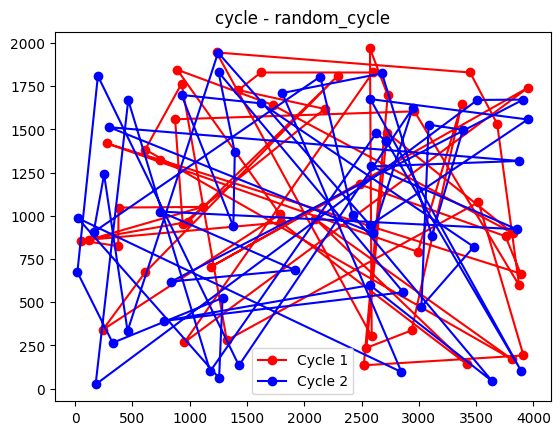

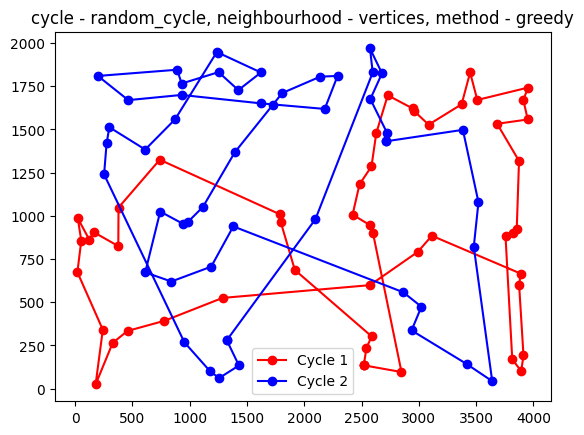

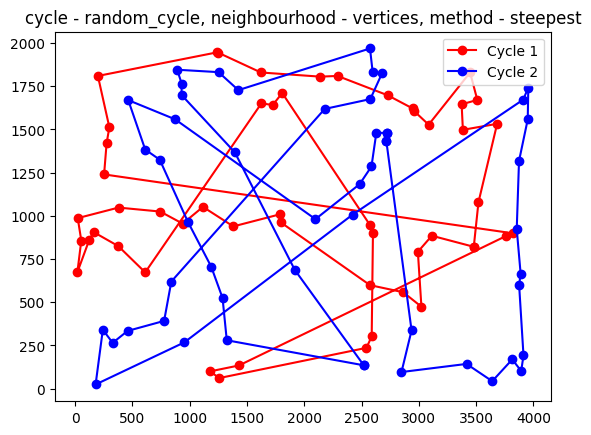

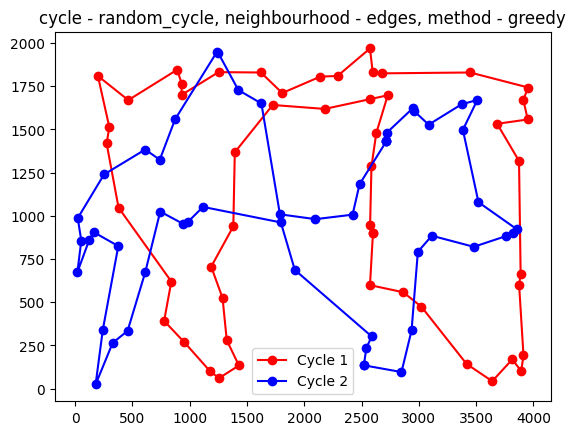

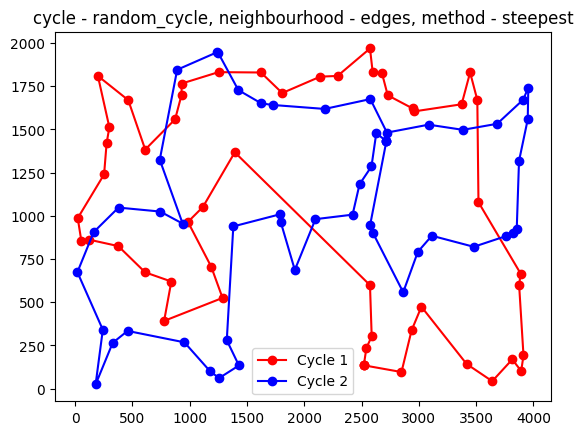

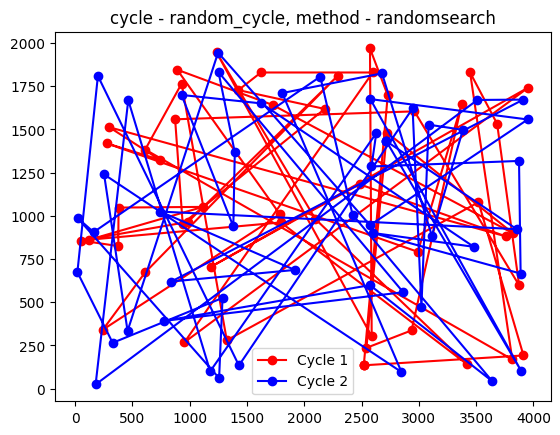

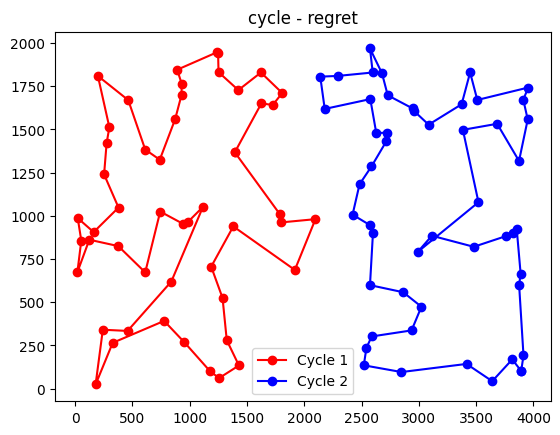

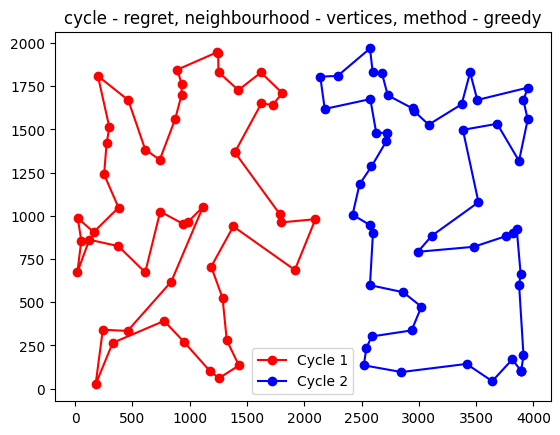

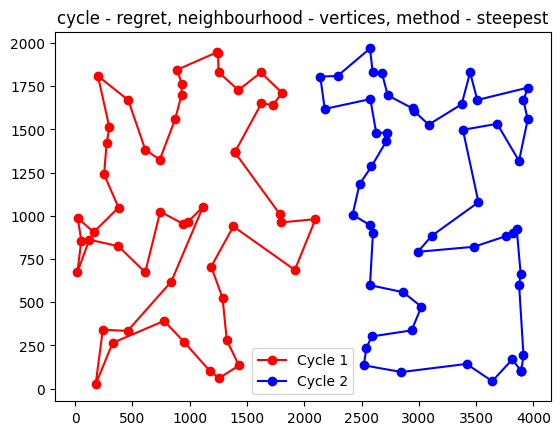

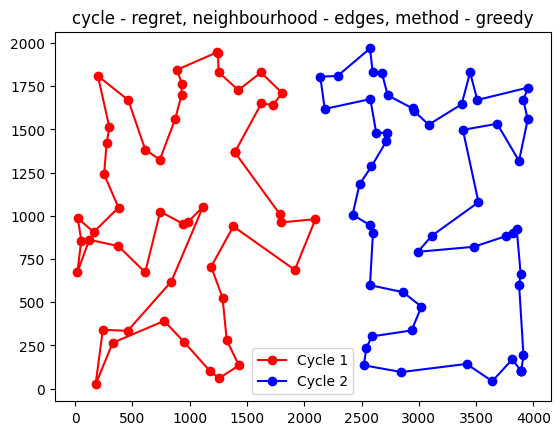

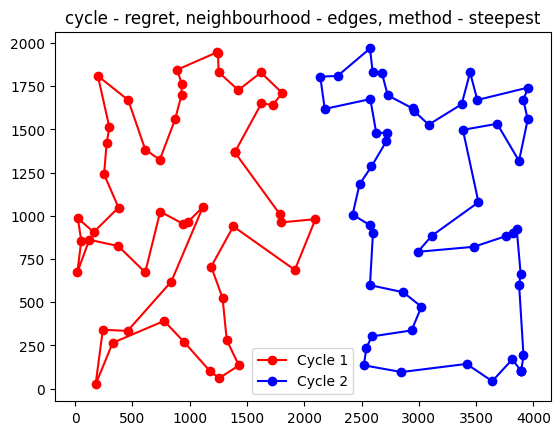

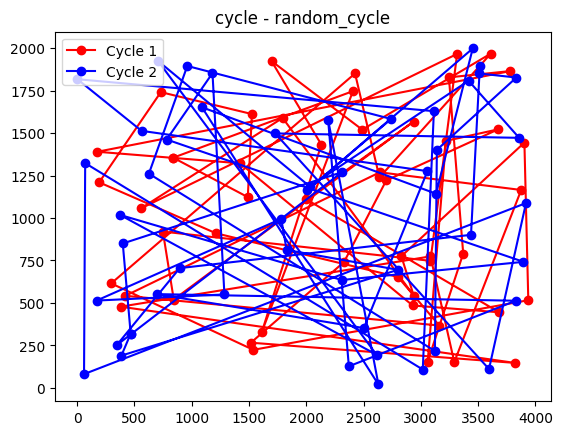

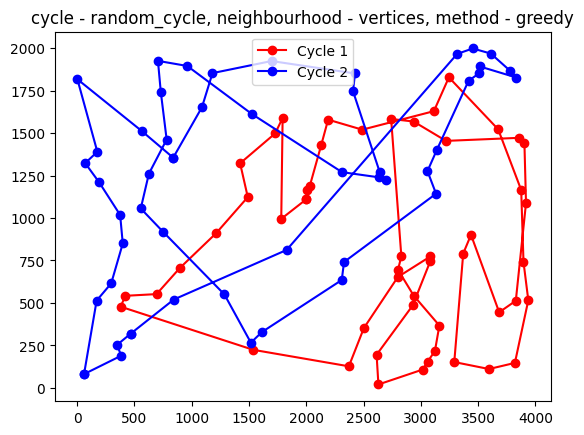

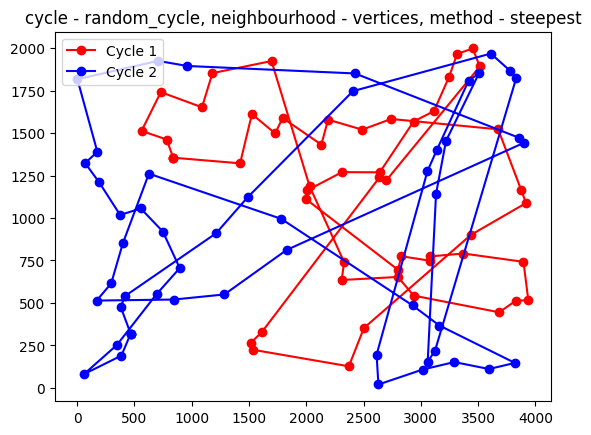

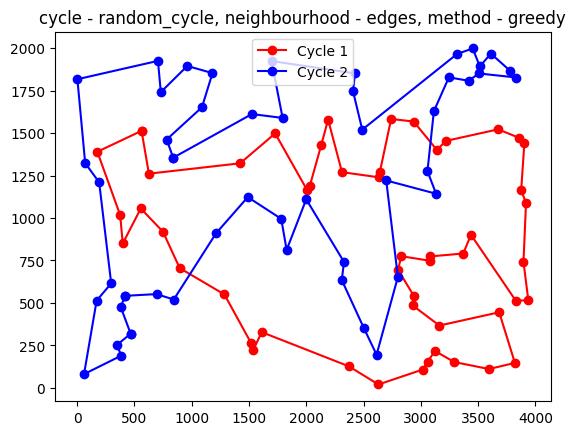

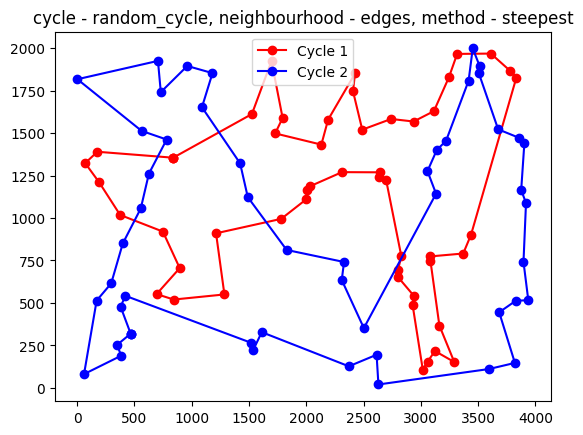

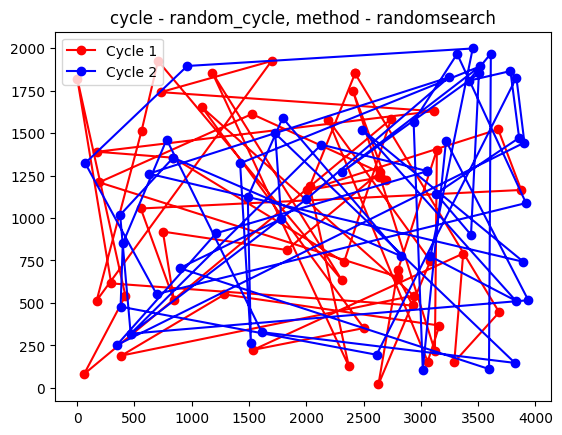

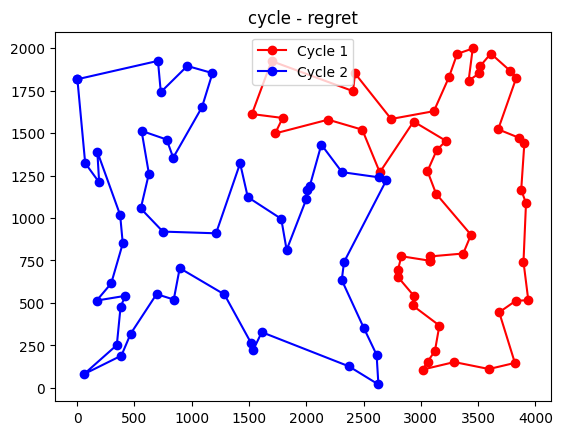

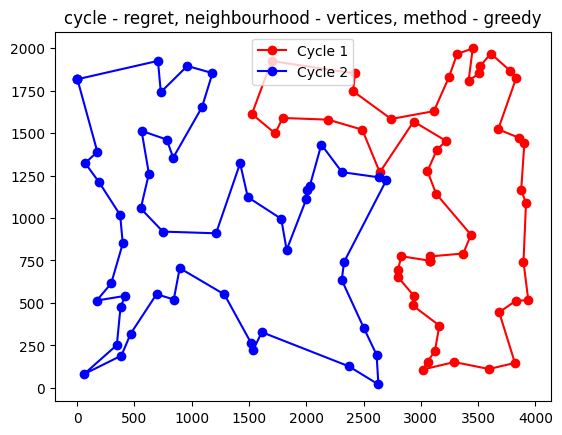

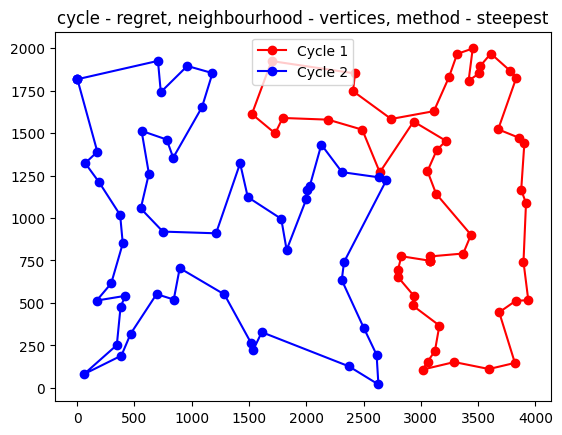

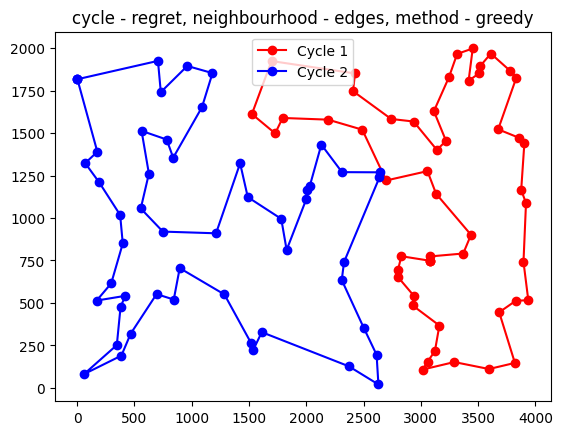

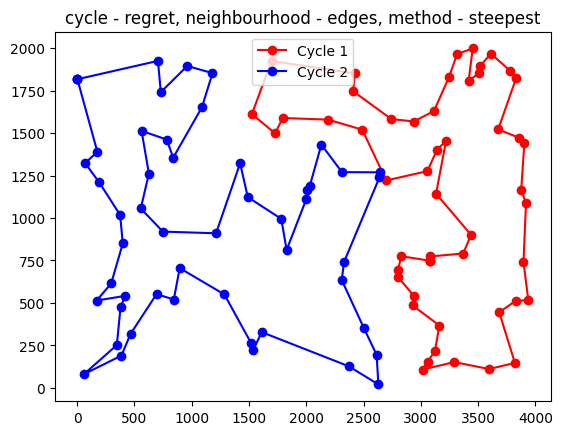

In [12]:
score_results = []
time_results = []
for file in ['kroa.csv','krob.csv']:
    coords = pd.read_csv(file, sep=' ')
    positions=np.array([coords['x'], coords['y']]).T
    cities = np.round(pairwise_distances(np.array(positions)))

    local_variants = [Steepest(cities, "edges")]
    # local_variants=[]
    # local_variants = [GreedySearch(cities, "vertices")]
    for solve in [regret]:
        solutions = list(map(solve, [(cities, i) for i in range(100)]))
        scores = [score(cities, x) for x in solutions]
        score_results.append(dict(file=file, function=solve.__name__, search="none", variant="none", min=int(min(scores)), mean=int(np.mean(scores)), max=int(max(scores))))
        best_idx = np.argmin(scores)
        best = solutions[best_idx]
        plot_optimized_tours(positions, *best, f'cycle - {solve.__name__}')
        for local_search in local_variants:
            times, new_solutions = zip(*list(map(local_search, solutions)))
            new_scores = [score(cities, x) for x in new_solutions]
            best = new_solutions[best_idx]
            plot_optimized_tours(positions, *best, f'cycle - {solve.__name__}, neighbourhood - {local_search.variant}, method - {(type(local_search).__name__).lower()}')
            score_results.append(dict(file=file, function=solve.__name__, search=type(local_search).__name__, variant=local_search.variant, min=int(min(new_scores)), mean=int(np.mean(new_scores)), max=int(max(new_scores))))
            time_results.append(dict(file=file, function=solve.__name__, search=type(local_search).__name__,variant=local_search.variant, min=float(min(times)), mean=float(np.mean(times)), max=float(max(times))))
scores = pd.DataFrame(score_results)
times = pd.DataFrame(time_results)

In [13]:
scores

,file,function,search,variant,min,mean,max
0,kroa.csv,random_cycle,none,none,143929,170590,193906
1,kroa.csv,random_cycle,Greedy,vertices,33237,40978,48236
2,kroa.csv,random_cycle,Steepest,vertices,34868,43543,54414
3,kroa.csv,random_cycle,Greedy,edges,25057,27603,30201
4,kroa.csv,random_cycle,Steepest,edges,24546,27899,31267
5,kroa.csv,random_cycle,RandomSearch,none,136283,143112,150389
6,kroa.csv,regret,none,none,22847,26911,30097
7,kroa.csv,regret,Greedy,vertices,22694,25499,28781
8,kroa.csv,regret,Steepest,vertices,22694,25437,28790
9,kroa.csv,regret,Greedy,edges,22384,25156,28033


In [14]:
times

,file,function,search,variant,min,mean,max
0,kroa.csv,random_cycle,Greedy,vertices,0.223357,0.330735,0.623962
1,kroa.csv,random_cycle,Steepest,vertices,0.876438,1.152324,1.543715
2,kroa.csv,random_cycle,Greedy,edges,0.221958,0.319230,0.466561
3,kroa.csv,random_cycle,Steepest,edges,0.700806,0.862921,1.496954
4,kroa.csv,regret,Greedy,vertices,0.010085,0.047925,0.127837
5,kroa.csv,regret,Steepest,vertices,0.017998,0.100937,0.220609
6,kroa.csv,regret,Greedy,edges,0.015240,0.049268,0.103933
7,kroa.csv,regret,Steepest,edges,0.022123,0.098694,0.228603
8,krob.csv,random_cycle,Greedy,vertices,0.215029,0.343411,0.531068
9,krob.csv,random_cycle,Steepest,vertices,0.871531,1.187486,1.606637
